<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類のタスクを実行
### 使用するデータセットの参考文献
 - https://b2share.eudat.eu/records/80df8606fcdb4b2bae1656f0dc6db8ba

## Google colabを使用の場合、ランタイムのタブから「ランタイムのタイプを変更」→ハードウェアアクセラレータと進み、T4 GPUを選択

### 右上の「接続」をクリックし、ランタイムに接続

In [1]:
# 以下のコマンドでGPUが使用可能かを確認
! nvidia-smi

Sun Apr 13 14:35:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## ライブラリをインストール

In [2]:
# CUDA 12.1 ビルドをインストール（書籍執筆時のPytorchの環境）※最新のGoogle Colabの環境でエラーが出る場合は本セルは実行しないこと（ただし、書籍掲載の結果と多少の差分が発生し得る。）
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [3]:
! pip install albumentations==1.4.20 timm==1.0.14 scikit-learn==1.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.5
    Uninstalling albumentations-2.0.5:
      Successfully uninstalled albumentations-2.0.5
  Attempting uninstall: timm
    Found existing installation: timm 1.0.15
    Uninstalling timm-1.0.15:
      Successfully uninstalled timm-1.0.15


### 「ランタイム」タブから「セッションを再起動する」を選択し、「はい」をクリック

## データセットのダウンロード
- https://b2share.eudat.eu/records/80df8606fcdb4b2bae1656f0dc6db8ba から Fibres.tar と Porous_Sponge.tar をダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、Fibres.tarをドラッグ＆ドロップしてアップロード
# Fibres.tarを以下のコマンドで解凍する
!tar -xvf Fibres.tar

Fibres/
Fibres/L9_ce66bc03e1dcb38f95eb3f13d6879f19.jpg
Fibres/L9_472f216128c9deb03adfe68d98d37478.jpg
Fibres/L9_b73b5f4c75fb066f76bd7601bcf2ea87.jpg
Fibres/L9_f8a3b60ce378b5295ccde3d9f81f6911.jpg
Fibres/L9_a51bfeb6c884d2183ea9683709ea6f53.jpg
Fibres/L9_0893b95691204e167abc892991e075ba.jpg
Fibres/L9_38109706a0514e58f2cecd8e3b1bb47d.jpg
Fibres/L9_af43a236f7eada10370dcbe98513a342.jpg
Fibres/L9_bd5b3c9fb047eae3af27eba36ac29593.jpg
Fibres/L9_c267746579433f789208dbbc8eee4330.jpg
Fibres/L9_85ba9459b8ff4f5621fffa232b253bfe.jpg
Fibres/L9_a26c96e7930665ed428791b3fe88ce92.jpg
Fibres/L9_ee1dc9c124191a5bd7ffc9c2f3e23551.jpg
Fibres/L9_e3899d1ae2a773ee9da752bac01ec6d9.jpg
Fibres/L9_834c5d932ead96e29cc7e672e3d0fb66.jpg
Fibres/L9_3b92d99835072f73f071561ed8ae96dd.jpg
Fibres/L9_7374c0eda182574f9c67b07b616b4fac.jpg
Fibres/L9_178353c48311c1c12b3e6a431d7d7019.jpg
Fibres/L9_01859de870ed8b8cf0415a0330ab8b11.jpg
Fibres/L9_be6276b32980202ccef2a7b4d9124f6b.jpg
Fibres/L9_b895fb0140a376804f9a4196bc3d60b7.jpg
Fibre

In [3]:
# Google Colabのファイルをクリックし、Porous_Sponge.tarをドラッグ＆ドロップしてアップロード
# Porous_Sponge.tarを以下のコマンドで解凍する
!tar -xvf Porous_Sponge.tar

Porous_Sponge/
Porous_Sponge/L0_cf9f11694caad1e286bedf582bb45456.jpg
Porous_Sponge/L0_7333ded956b39296bbf8379c39d70682.jpg
Porous_Sponge/L0_35da4528991365232bec1278d5456bbc.jpg
Porous_Sponge/L0_fc3543ca184b0e8340559b6ed6a5686a.jpg
Porous_Sponge/L0_9df743ce3d6097d610fd145c07895ea0.jpg
Porous_Sponge/L0_1bb457a9dae682696fdce19955bc1360.jpg
Porous_Sponge/L0_18d2c6b2f552be88041cba8beb378ab4.jpg
Porous_Sponge/L0_1c34778dec5a1701d689a7067c4813eb.jpg
Porous_Sponge/L0_0f33d3d0e9efbe60c16a2aa1af3e128d.jpg
Porous_Sponge/L0_df0c51c3537b6933ea08467339d3eaee.jpg
Porous_Sponge/L0_273b2fe2c224173a255d9c03d4c98c32.jpg
Porous_Sponge/L0_2ce557ad129572b8d8258f440fbdec2e.jpg
Porous_Sponge/L0_74f696205ed9a1c0a355d0a7fa59addf.jpg
Porous_Sponge/L0_f38f03e44dd36406590945a374402a26.jpg
Porous_Sponge/L0_6fcbe32aaa0e3bcf95d61460991caeb6.jpg
Porous_Sponge/L0_109dd70cc8f44651f0e1f76837057e56.jpg
Porous_Sponge/L0_028965453585464cfda6b7df06e0bc39.jpg
Porous_Sponge/L0_6259b0d2848cd69f0aac5bb927d7109c.jpg
Porous_Sponge

In [4]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [5]:
import gc
import glob
import os
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

import cv2
import imageio
import sklearn.exceptions
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# pytorchのverを確認
print(torch.__version__)

2.5.1+cu121


## random seed、デバイスの設定

In [7]:
# seedの固定
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## 画像の読み込みと表示

In [8]:
# Fibresの画像のパスを取得
train_path_fibres = (
    INPUT_FILE_PATH + "Fibres"
)
train_files_fibres = sorted(glob.glob(os.path.join(train_path_fibres, "*.jpg")))
print(f"Fibres data: {len(train_files_fibres)}")

Fibres data: 150


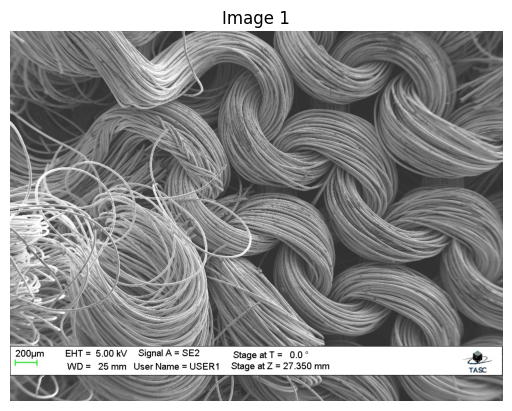

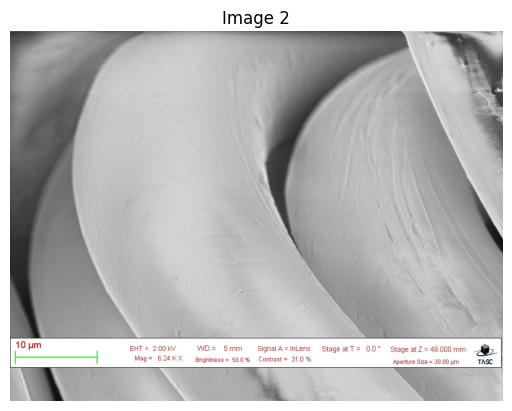

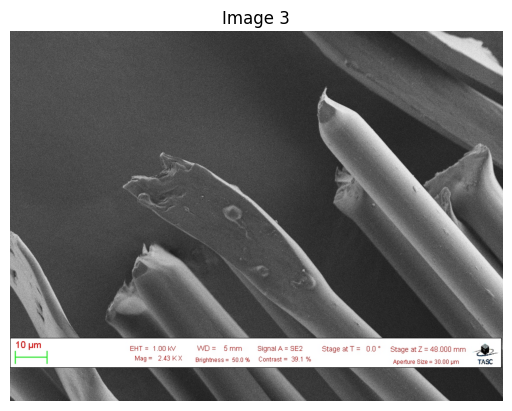

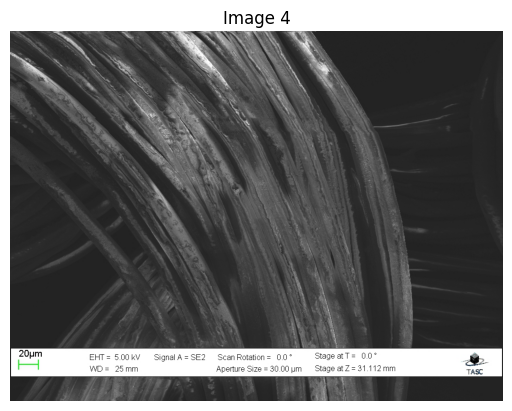

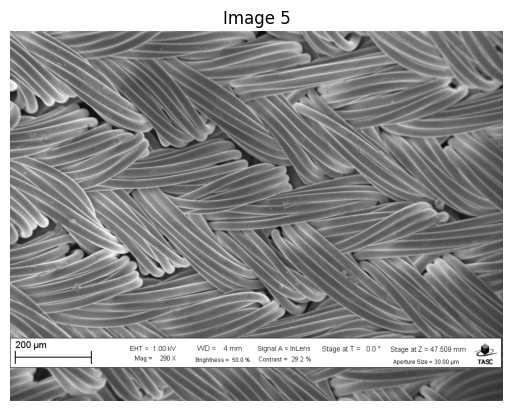

In [9]:
# Fibresの画像を表示
for i in range(5):
  img = cv2.imread(train_files_fibres[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title(f"Image {i+1}")
  plt.axis('off')
  plt.show()

In [10]:
# Porous_Spongeの画像のパスを取得
train_path_porous_sponge = (
    INPUT_FILE_PATH + "Porous_Sponge"
)
train_files_porous_sponge = sorted(glob.glob(os.path.join(train_path_porous_sponge, "*.jpg")))
print(f"Fibres data: {len(train_files_porous_sponge)}")

Fibres data: 174


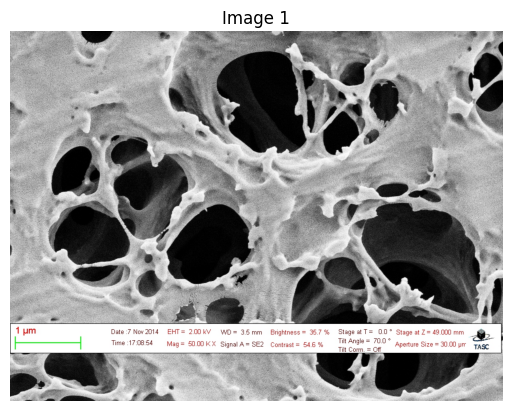

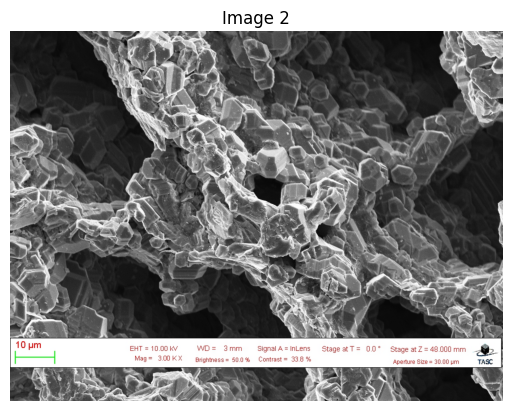

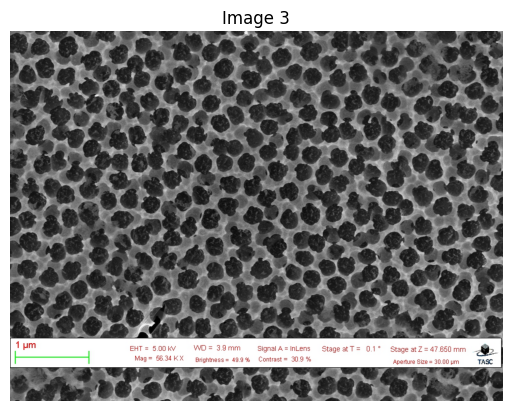

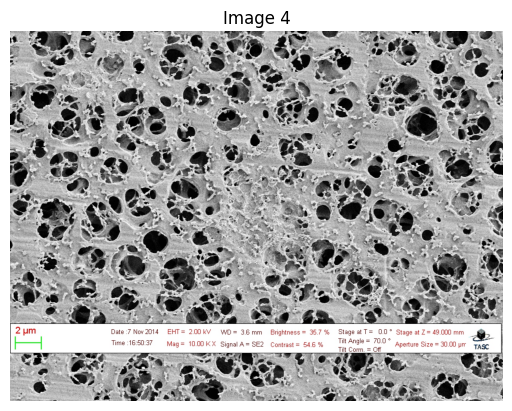

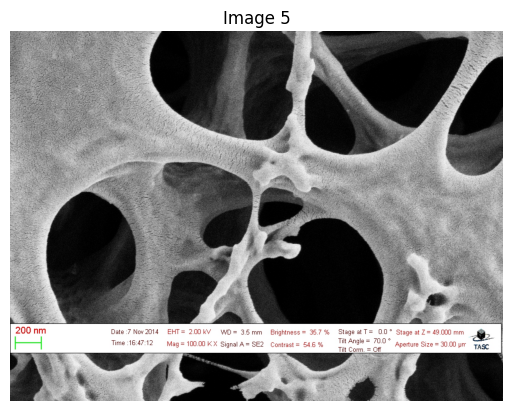

In [11]:
# Porous_Spongeの画像を表示
for i in range(5):
  img = cv2.imread(train_files_porous_sponge[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title(f"Image {i+1}")
  plt.axis('off')
  plt.show()

## データを学習データ、検証データに分割

In [12]:
# データの準備（Fibresの画像を0、Porous_Spongeの画像を1として2値分類用のデータを準備）
train_df__fibres = pd.DataFrame(train_files_fibres, columns=["file_path"])
train_df__fibres["label"] = 0
train_df__porous_sponge = pd.DataFrame(train_files_porous_sponge, columns=["file_path"])
train_df__porous_sponge["label"] = 1
train_df = pd.concat([train_df__fibres, train_df__porous_sponge], axis=0)
train_df = train_df.reset_index(drop=True)
train_df

,file_path,label
0,./Fibres/L9_00fc0a86bd4f02995acdd5b3f63401b9.jpg,0
1,./Fibres/L9_01859de870ed8b8cf0415a0330ab8b11.jpg,0
2,./Fibres/L9_0450a577e0cfb2f9f9d6e746c4d673fc.jpg,0
3,./Fibres/L9_057096dc6ac2258ad49ab53928894356.jpg,0
4,./Fibres/L9_0893b95691204e167abc892991e075ba.jpg,0
...,...,...
319,./Porous_Sponge/L0_f9f4e00ff6fa2e1d9355c9e5d23...,1
320,./Porous_Sponge/L0_fa2b0f226b5da8a8a34a1358040...,1
321,./Porous_Sponge/L0_fc3543ca184b0e8340559b6ed6a...,1
322,./Porous_Sponge/L0_fd457d57395fa7c8560c4728806...,1


In [13]:
# train_dfを学習データと検証データに分割
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, valid_index) in enumerate(
    skf.split(train_df, train_df["label"])
):
    train_df.loc[valid_index, "fold"] = fold
train_df["fold"] = train_df["fold"].astype(int)

train_df

,file_path,label,fold
0,./Fibres/L9_00fc0a86bd4f02995acdd5b3f63401b9.jpg,0,2
1,./Fibres/L9_01859de870ed8b8cf0415a0330ab8b11.jpg,0,0
2,./Fibres/L9_0450a577e0cfb2f9f9d6e746c4d673fc.jpg,0,3
3,./Fibres/L9_057096dc6ac2258ad49ab53928894356.jpg,0,2
4,./Fibres/L9_0893b95691204e167abc892991e075ba.jpg,0,2
...,...,...,...
319,./Porous_Sponge/L0_f9f4e00ff6fa2e1d9355c9e5d23...,1,1
320,./Porous_Sponge/L0_fa2b0f226b5da8a8a34a1358040...,1,0
321,./Porous_Sponge/L0_fc3543ca184b0e8340559b6ed6a...,1,4
322,./Porous_Sponge/L0_fd457d57395fa7c8560c4728806...,1,4


## 画像分類モデルの構築

In [14]:
# データセットの作成
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df["file_path"].values[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )  # cv2.imreadで読み込んだ画像はBGRで読み込まれるため、RGBに変換する。pilowで画像を読み込む場合は、変換の必要はない。
        if self.transform:
            image = self.transform(image=image)["image"]
        label = self.df["label"].values[idx]
        return image, label


# データ拡張の設定
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ] # 学習データにはデータ拡張を行う
)

valid_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(), ToTensorV2()]
)  # 検証データにはデータ拡張を行わず、リサイズと正規化のみを行う。

# データセットの作成（今回はfold0を検証データ、それ以外を学習データとしてSingle holdでの検証としている）
train_dataset = ImageDataset(train_df[train_df["fold"] != 0], transform=transform)
valid_dataset = ImageDataset(train_df[train_df["fold"] == 0], transform=valid_transform)

# データローダーの作成
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)  # shuffle=Trueに設定すると、エポックごとに訓練データがランダムにシャッフルされる。これにより、モデルが訓練データを学習する順序が毎回異なり、過学習を防ぐ効果がある。
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False
)  # shuffle=Falseに設定すると、データがシャッフルされない。検証データはシャッフルする必要がないため、Falseに設定する。

# モデルの作成
model = timm.create_model(
    "resnet18", pretrained=False, num_classes=1
)  # num_clases=1として2値分類を行うため、最終層の出力ユニット数を1に設定する。
model = model.to(device)

# 損失関数の設定
criterion = nn.BCEWithLogitsLoss()

# オプティマイザの設定
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 学習率スケジューラの設定
num_epochs = 30
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# モデル保存のための初期化
best_valid_loss = float("inf")
save_path = "best_model.pth"

# 損失を記録するリスト
train_losses = []
valid_losses = []

# 学習の実行
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 検証ループ
    model.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    # 改善された場合にモデルを保存
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")

    print(
        f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}"
    )

    # スケジューラのステップ
    scheduler.step()

print(f"Best validation loss: {best_valid_loss:.4f}, Model saved to {save_path}")

Model saved at epoch 1 with validation loss 0.6817
Epoch: 1/30, Train Loss: 0.6503, Valid Loss: 0.6817


Epoch: 2/30, Train Loss: 0.6174, Valid Loss: 0.6826


Model saved at epoch 3 with validation loss 0.6787
Epoch: 3/30, Train Loss: 0.5440, Valid Loss: 0.6787


Model saved at epoch 4 with validation loss 0.6242
Epoch: 4/30, Train Loss: 0.5536, Valid Loss: 0.6242


Model saved at epoch 5 with validation loss 0.5718
Epoch: 5/30, Train Loss: 0.5136, Valid Loss: 0.5718


Model saved at epoch 6 with validation loss 0.5109
Epoch: 6/30, Train Loss: 0.4598, Valid Loss: 0.5109


Model saved at epoch 7 with validation loss 0.4389
Epoch: 7/30, Train Loss: 0.5053, Valid Loss: 0.4389


Model saved at epoch 8 with validation loss 0.4010
Epoch: 8/30, Train Loss: 0.4336, Valid Loss: 0.4010


Model saved at epoch 9 with validation loss 0.3347
Epoch: 9/30, Train Loss: 0.4337, Valid Loss: 0.3347


Model saved at epoch 10 with validation loss 0.2959
Epoch: 10/30, Train Loss: 0.4696, Valid Loss: 0.2959


Model saved at epoch 11 with validation loss 0.2792
Epoch: 11/30, Train Loss: 0.4097, Valid Loss: 0.2792


Model saved at epoch 12 with validation loss 0.2609
Epoch: 12/30, Train Loss: 0.5203, Valid Loss: 0.2609


Model saved at epoch 13 with validation loss 0.2557
Epoch: 13/30, Train Loss: 0.4720, Valid Loss: 0.2557


Model saved at epoch 14 with validation loss 0.2506
Epoch: 14/30, Train Loss: 0.4152, Valid Loss: 0.2506


Model saved at epoch 15 with validation loss 0.2474
Epoch: 15/30, Train Loss: 0.4771, Valid Loss: 0.2474


Model saved at epoch 16 with validation loss 0.2467
Epoch: 16/30, Train Loss: 0.4149, Valid Loss: 0.2467


Model saved at epoch 17 with validation loss 0.2434
Epoch: 17/30, Train Loss: 0.4747, Valid Loss: 0.2434


Epoch: 18/30, Train Loss: 0.4038, Valid Loss: 0.2438


Model saved at epoch 19 with validation loss 0.2423
Epoch: 19/30, Train Loss: 0.4441, Valid Loss: 0.2423


Model saved at epoch 20 with validation loss 0.2394
Epoch: 20/30, Train Loss: 0.4457, Valid Loss: 0.2394


Epoch: 21/30, Train Loss: 0.4098, Valid Loss: 0.2408


Model saved at epoch 22 with validation loss 0.2389
Epoch: 22/30, Train Loss: 0.4850, Valid Loss: 0.2389


Model saved at epoch 23 with validation loss 0.2382
Epoch: 23/30, Train Loss: 0.3915, Valid Loss: 0.2382


Epoch: 24/30, Train Loss: 0.4415, Valid Loss: 0.2400


Epoch: 25/30, Train Loss: 0.3967, Valid Loss: 0.2442


Epoch: 26/30, Train Loss: 0.4926, Valid Loss: 0.2398


Epoch: 27/30, Train Loss: 0.3973, Valid Loss: 0.2429


Epoch: 28/30, Train Loss: 0.4182, Valid Loss: 0.2472


Epoch: 29/30, Train Loss: 0.3901, Valid Loss: 0.2448


Epoch: 30/30, Train Loss: 0.4121, Valid Loss: 0.2409
Best validation loss: 0.2382, Model saved to best_model.pth


## 構築したモデルの評価

In [15]:
# 検証データにおける正解率とF1スコアを計算
valid_preds = []
valid_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        valid_preds.extend(preds)
        valid_labels.extend(labels.cpu().numpy())
valid_preds = np.array(valid_preds).flatten()

In [16]:
# valid_predsとvalid_labelsを比較して、scikit-learnのモジュールを使用して正解率とF1スコアを計算
valid_preds = np.where(valid_preds > 0.5, 1, 0)
valid_labels = np.array(valid_labels).flatten()
accuracy = accuracy_score(valid_labels, valid_preds)
f1 = f1_score(valid_labels, valid_preds)
print(f"Accuracy: {accuracy:.2f}, F1: {f1:.2f}")

Accuracy: 0.86, F1: 0.88


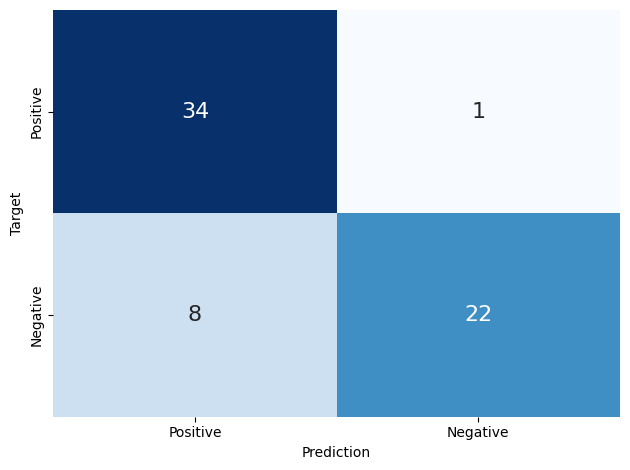

In [17]:
# confusion matrixを左上がTrue Positive、右上がFalse Positive、左下がFalse Negative、右下がTrue Negativeになるように可視化
cm = confusion_matrix(valid_labels, valid_preds)
sns.heatmap(
    cm[::-1, ::-1],
    annot=True,
    cmap="Blues",
    fmt="d",
    cbar=False,
    annot_kws={"size": 16},
)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])
plt.tight_layout()
plt.show()

## 実行環境のライブラリverを保存

In [18]:
# Pythonのverを確認
!python3 -V

Python 3.11.12


In [19]:
!pip freeze > requirements_image_classification.txt

In [20]:
from google.colab import files

files.download('requirements_image_classification.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>